In [1]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
import scipy.stats as stats
from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from xgboost import XGBClassifier, XGBRegressor

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
#Import 2015 and 2017 census data, change column names to be consistent across datasets

df2015 = pd.read_csv('acs2015_census_tract_data.csv')

df2017 = pd.read_csv('acs2017_census_tract_data.csv')
df2017.rename({'TractId': 'CensusTract', 'VotingAgeCitizen': 'Citizen'}, axis=1, inplace=True)

In [3]:
#Change count statistics to percentages based on total population; remove %women because of perfect multicollinearity with %men

df2015['Men'] = df2015['Men']/df2015['TotalPop']
df2015['Citizen'] = df2015['Citizen']/df2015['TotalPop']
df2015['Employed'] = df2015['Employed']/df2015['TotalPop']
df2015.drop(['CensusTract', 'Women'], axis=1, inplace=True)

df2017['Men'] = df2017['Men']/df2017['TotalPop']
df2017['Citizen'] = df2017['Citizen']/df2017['TotalPop']
df2017['Employed'] = df2017['Employed']/df2017['TotalPop']
df2017.drop(['CensusTract', 'Women'], axis=1, inplace=True)

In [4]:
#Create df_diff as change from 2015 to 2017
#Add Poverty_Change variable as categorical, -1=significant decrease in poverty, 0=no significant change, +1=significant increase in poverty

df_diff = df2017.copy()
df_diff.drop(['State', 'County'], axis=1, inplace=True)
for col in df_diff:
        df_diff[col] = df2017[col] - df2015[col]
df_diff['Poverty_Change'] = 0
df_diff.loc[(df_diff['Poverty'] >= 1.5), 'Poverty_Change'] = 1
df_diff.loc[(df_diff['Poverty'] <= -1.5), 'Poverty_Change'] = -1

#Add poverty change to 2015 dataset
df2015['Poverty_Change'] = df_diff['Poverty_Change']
df2015['Poverty_Change_val'] = df_diff['Poverty']

df2015['Poverty_Change_2c'] = 0
df2015.loc[(df2015['Poverty_Change_val'] < 0), 'Poverty_Change_2c'] = 1

In [5]:
#Create PCA components for a combination of 'State' and 'County' variables

pca = PCA(n_components=10)
principal_components = pca.fit_transform(pd.concat([pd.get_dummies(df2015['State']), pd.get_dummies(df2015['County'])], axis=1))

principalDf = pd.DataFrame(data = principal_components)
df2015 = pd.concat([df2015, principalDf], axis=1)

In [6]:
#Drop null values

df2015.dropna(inplace=True)
df_diff.dropna(inplace=True)

In [7]:
#Winsorize outliers

for col in df2015.columns[2:]:
    threshold = 5
    q75, q25 = np.percentile(df2015[col], [75,25])
    iqr = q75-q25
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)

    outliers = df2015[(df2015[col] > max_val) | (df2015[col] < min_val)]
    print(col)
    print('There are {} tracts identified as outliers.'.format(outliers.shape[0]))

    df2015[col] = pd.Series(winsorize(df2015[col], limits = (outliers.shape[0]/df2015[col].shape[0])))

for col in df_diff.columns:
    threshold = 3
    q75, q25 = np.percentile(df_diff[col], [75,25])
    iqr = q75-q25
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)

    outliers = df_diff[(df_diff[col] > max_val) | (df_diff[col] < min_val)]
    print(col)
    print('There are {} tracts identified as outliers.'.format(outliers.shape[0]))

    df_diff[col] = pd.Series(winsorize(df_diff[col], limits = (outliers.shape[0]/df_diff[col].shape[0])))

TotalPop
There are 66 tracts identified as outliers.
Men
There are 160 tracts identified as outliers.
Hispanic
There are 0 tracts identified as outliers.
White
There are 0 tracts identified as outliers.
Black
There are 2367 tracts identified as outliers.
Native
There are 3223 tracts identified as outliers.
Asian
There are 2205 tracts identified as outliers.
Pacific
There are 8847 tracts identified as outliers.
Citizen
There are 2 tracts identified as outliers.
Income
There are 22 tracts identified as outliers.
IncomeErr
There are 223 tracts identified as outliers.
IncomePerCap
There are 221 tracts identified as outliers.
IncomePerCapErr
There are 688 tracts identified as outliers.
Poverty
There are 0 tracts identified as outliers.
ChildPoverty
There are 0 tracts identified as outliers.
Professional
There are 0 tracts identified as outliers.
Service
There are 1 tracts identified as outliers.
Office
There are 1 tracts identified as outliers.
Construction
There are 35 tracts identified as

In [8]:
#Drop null values

df2015.dropna(inplace=True)
df_diff.dropna(inplace=True)

In [55]:
#Create y-variable as categorical poverty change, X variable as all 2015 statistics
#Perform train test split; also create "small" dataset for faster computation during testing
#Create scaled dataset for use when necessary

y = df2015['Poverty_Change']

#Remove ChildPoverty and PrivateWork for too much correlation with Poverty and PublicWork respectively

X = df2015.drop(['State', 'County', 'Poverty_Change', 'Poverty_Change_val', 'Poverty_Change_2c', 'ChildPoverty', 'PrivateWork'], axis=1)

# df_small = df2015.sample(frac=0.1)
# y_small = df_small['Poverty_Change_2c']
# X_small = df_small.drop(['State', 'County', 'Poverty_Change', 'Poverty_Change_val', 'Poverty_Change_2c'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_small,y_small,test_size=0.2)

scaler = StandardScaler()
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scale = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
# X_train_s_scale = pd.DataFrame(scaler.fit_transform(X_train_s), columns = X_train_s.columns)
# X_test_s_scale = pd.DataFrame(scaler.fit_transform(X_test_s), columns = X_test_s.columns)

In [56]:
#Oversample training data to equalize class sizes

sm = SMOTE()

X_train_res, y_train_res = sm.fit_resample(X_train_scale, y_train)

0.3871508965710091
0.3890248164977281


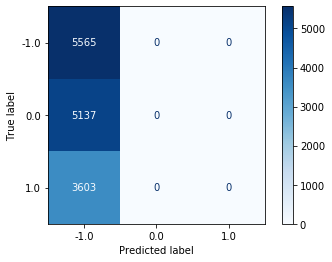

In [11]:
#Perform dummy classification for baseline

dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train)

print(dummy.score(X_train, y_train))
print(dummy.score(X_test, y_test))

plot_confusion_matrix(dummy, X_test, y_test, cmap='Blues')

# Multiple models were analyzed, including logistic regression, support vector machines, random forest, and gradient boosting models. Models were tested on unmodified training data (scaled where appropriate) and oversampled data. Logistic regression trained on oversampled data was determined to be the best model due to highest recall for the +1 class while maintaining a similar overall accuracy score to the other models.

Perform analysis on a series of logistic regression models to identify best parameters

0.5172323394735923
0.5156239077245718
--- 4.039045095443726 seconds ---


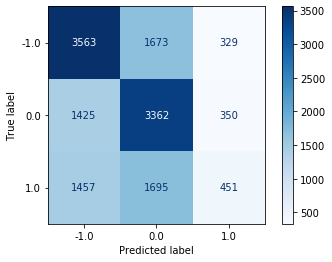

In [12]:
start_time = time.time()

logit = LogisticRegression(max_iter=10000)

logit.fit(X_train_scale, y_train)
print(logit.score(X_train_scale, y_train))
print(logit.score(X_test_scale, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit, X_test_scale, y_test, cmap='Blues')

0.4882779583483809
0.49449473941766575
0.4859839217056973
--- 23.664801597595215 seconds ---


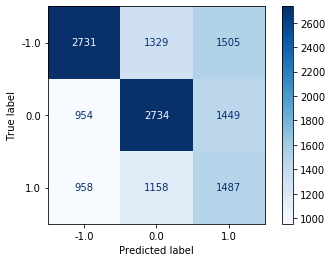

In [13]:
start_time = time.time()

logit_smote_saga = LogisticRegression(max_iter=10000, solver='saga')

logit_smote_saga.fit(X_train_res, y_train_res)
print(logit_smote_saga.score(X_train_res, y_train_res))
print(logit_smote_saga.score(X_train_scale, y_train))
print(logit_smote_saga.score(X_test_scale, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit_smote_saga, X_test_scale, y_test, cmap='Blues')

0.488353196099675
0.49461707854171766
0.4861936385879063
--- 12.80456256866455 seconds ---


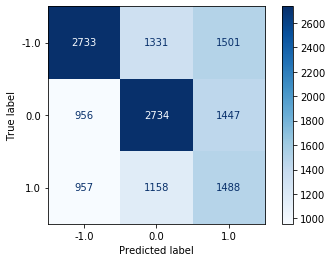

In [14]:
start_time = time.time()

logit_smote_saga2 = LogisticRegression(max_iter=10000, solver='saga', penalty='l1')

logit_smote_saga2.fit(X_train_res, y_train_res)
print(logit_smote_saga2.score(X_train_res, y_train_res))
print(logit_smote_saga2.score(X_train_scale, y_train))
print(logit_smote_saga2.score(X_test_scale, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit_smote_saga2, X_test_scale, y_test, cmap='Blues')

0.48833814854941615
0.49458212450627426
0.4860538273331003
--- 39.4800968170166 seconds ---


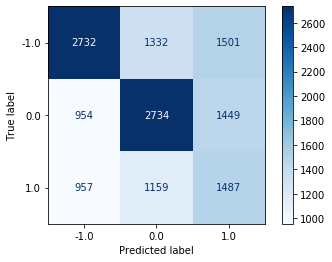

In [15]:
start_time = time.time()

logit_smote_saga3 = LogisticRegression(max_iter=10000, solver='saga', penalty='elasticnet', l1_ratio=0.5)

logit_smote_saga3.fit(X_train_res, y_train_res)
print(logit_smote_saga3.score(X_train_res, y_train_res))
print(logit_smote_saga3.score(X_train_scale, y_train))
print(logit_smote_saga3.score(X_test_scale, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit_smote_saga3, X_test_scale, y_test, cmap='Blues')

0.4885488142530396
0.4964521654024957
0.48975882558545963
--- 44.74257564544678 seconds ---


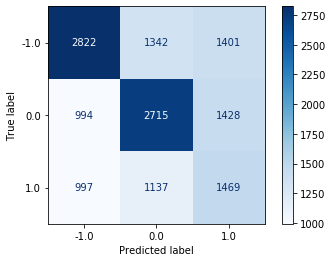

In [16]:
start_time = time.time()

logit_smote_saga_ovr = LogisticRegression(max_iter=10000, solver='saga', multi_class='ovr')

logit_smote_saga_ovr.fit(X_train_res, y_train_res)
print(logit_smote_saga_ovr.score(X_train_res, y_train_res))
print(logit_smote_saga_ovr.score(X_train_scale, y_train))
print(logit_smote_saga_ovr.score(X_test_scale, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit_smote_saga_ovr, X_test_scale, y_test, cmap='Blues')

0.488518719152522
0.4964521654024957
0.48954910870325063
--- 7.096336603164673 seconds ---


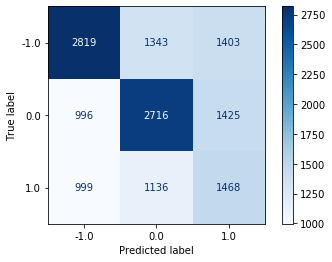

In [17]:
start_time = time.time()

logit_smote_saga_ovr2 = LogisticRegression(max_iter=10000, solver='saga', multi_class='ovr', penalty='l1')

logit_smote_saga_ovr2.fit(X_train_res, y_train_res)
print(logit_smote_saga_ovr2.score(X_train_res, y_train_res))
print(logit_smote_saga_ovr2.score(X_train_scale, y_train))
print(logit_smote_saga_ovr2.score(X_test_scale, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit_smote_saga_ovr2, X_test_scale, y_test, cmap='Blues')

0.4886090044540749
0.4965395504911042
0.48975882558545963
--- 14.733221054077148 seconds ---


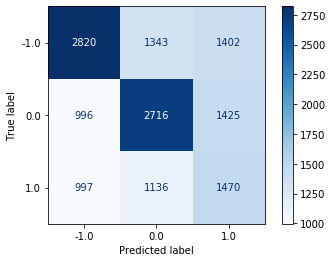

In [18]:
start_time = time.time()

logit_smote_saga_ovr3 = LogisticRegression(max_iter=10000, solver='saga', multi_class='ovr', penalty='elasticnet', l1_ratio=0.5)

logit_smote_saga_ovr3.fit(X_train_res, y_train_res)
print(logit_smote_saga_ovr3.score(X_train_res, y_train_res))
print(logit_smote_saga_ovr3.score(X_train_scale, y_train))
print(logit_smote_saga_ovr3.score(X_test_scale, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit_smote_saga_ovr3, X_test_scale, y_test, cmap='Blues')

# After analyzing multiple parameters in logistic regression, including normalization levels (C parameter), multivariate analysis method, and loss function, the best model was determined to be a multivariate analysis with L2 loss. Normalization level did not have a significant impact on any of the models, so C=1 was chosen for best run time.

In [19]:
# c = [0.1, 0.5, 1, 10, 20, 40 ,70, 90, 100]

In [20]:
# for i in c:
#     start_time = time.time()

#     logit_smote_saga = LogisticRegression(max_iter=10000, solver='saga', C=i)

#     logit_smote_saga.fit(X_train_res, y_train_res)
#     print(logit_smote_saga.score(X_train_res, y_train_res))
#     print(logit_smote_saga.score(X_train_scale, y_train))
#     print(logit_smote_saga.score(X_test_scale, y_test))

#     print("--- %s seconds ---" % (time.time() - start_time))

#     print(plot_confusion_matrix(logit_smote_saga, X_test_scale, y_test, cmap='Blues'))

Variations in C make no significant difference in test accuracy or identification of the +1 class.

In [21]:
# for i in c:
#     start_time = time.time()

#     logit_smote_saga2 = LogisticRegression(max_iter=10000, solver='saga', penalty='l1', C=i)

#     logit_smote_saga2.fit(X_train_res, y_train_res)
#     print(logit_smote_saga2.score(X_train_res, y_train_res))
#     print(logit_smote_saga2.score(X_train_scale, y_train))
#     print(logit_smote_saga2.score(X_test_scale, y_test))

#     print("--- %s seconds ---" % (time.time() - start_time))

#     print(plot_confusion_matrix(logit_smote_saga2, X_test_scale, y_test, cmap='Blues'))

Variations in C make no significant difference in test accuracy or identification of the +1 class.

In [22]:
# for i in c:
#     start_time = time.time()

#     logit_smote_saga_ovr = LogisticRegression(max_iter=10000, solver='saga', multi_class='ovr', C=i)

#     logit_smote_saga_ovr.fit(X_train_res, y_train_res)
#     print(logit_smote_saga_ovr.score(X_train_res, y_train_res))
#     print(logit_smote_saga_ovr.score(X_train_scale, y_train))
#     print(logit_smote_saga_ovr.score(X_test_scale, y_test))

#     print("--- %s seconds ---" % (time.time() - start_time))

#     print(plot_confusion_matrix(logit_smote_saga_ovr, X_test_scale, y_test, cmap='Blues'))

Variations in C make no significant difference in test accuracy or identification of the +1 class.

In [23]:
# for i in c:
#     start_time = time.time()

#     logit_smote_saga_ovr2 = LogisticRegression(max_iter=10000, solver='saga', multi_class='ovr', penalty='l1', C=i)

#     logit_smote_saga_ovr2.fit(X_train_res, y_train_res)
#     print(logit_smote_saga_ovr2.score(X_train_res, y_train_res))
#     print(logit_smote_saga_ovr2.score(X_train_scale, y_train))
#     print(logit_smote_saga_ovr2.score(X_test_scale, y_test))

#     print("--- %s seconds ---" % (time.time() - start_time))

#     print(plot_confusion_matrix(logit_smote_saga_ovr2, X_test_scale, y_test, cmap='Blues'))

Variations in C make no significant difference in test accuracy or identification of the +1 class.

0.4882779583483809
0.49449473941766575
0.4859839217056973
--- 24.563348293304443 seconds ---


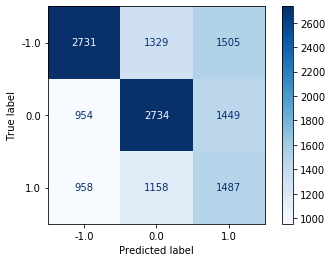

In [24]:
start_time = time.time()

logit_final = LogisticRegression(max_iter=10000, solver='saga')

logit_final.fit(X_train_res, y_train_res)
print(logit_final.score(X_train_res, y_train_res))
print(logit_final.score(X_train_scale, y_train))
print(logit_final.score(X_test_scale, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

plot_confusion_matrix(logit_final, X_test_scale, y_test, cmap='Blues')

In [25]:
for i in range(len(X_test.columns)):
    print(X_test.columns[i])
    print(logit_smote_saga.coef_[2,i] - logit_smote_saga.coef_[0,i])

TotalPop
-0.11873984384759596
Men
-0.019605054020887698
Hispanic
0.11064372111041519
White
-0.2432711638983321
Black
0.0637605133680973
Native
-0.03438599413073055
Asian
0.009523825949563764
Pacific
0.0
Citizen
0.13943802715006784
Income
-0.25972061170756555
IncomeErr
-0.03360020344851414
IncomePerCap
0.16127694912350604
IncomePerCapErr
-0.10366953240603956
Poverty
-1.0515689061550098
Professional
-0.48126346232134637
Service
-0.19400212817148138
Office
-0.1889499960578775
Construction
-0.19204916736469263
Production
-0.22774912655683072
Drive
-0.04563730932705226
Carpool
-0.022407999880941287
Transit
-0.04071959587341331
Walk
0.1452873895375643
OtherTransp
0.020408087958044174
WorkAtHome
-0.08525549084682674
MeanCommute
-0.08490990212382887
Employed
-0.20144039658487628
PublicWork
0.02555496820710452
SelfEmployed
-0.05252678494560246
FamilyWork
0.0
Unemployment
0.07830545735000907
0
-0.08457817860913316
1
0.01843402013162356
2
0.025105839170013095
3
-0.03442066343404191
4
-0.019858526

The most impactful variables in differentiating between the +1 and the -1 classes are the poverty rate (-1.03), the percentage of the population that is white (-0.28), the median household income (-0.25), the percentage of professionals, or the percentage working in business, management, science, and the arts (-0.40), the percentage of the population that is employed (-0.21), the percentage of the population that walks to work (+0.16), income per capita (+0.20), and the percentage of the population that are US citizens (+0.14). A positive coefficient value indicates prediction of the +1 class over the -1 class, and a negative coefficient value indicates prediction of the -1 class over the +1 class.

In [48]:
start_time = time.time()

boost_c = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=2, subsample=0.5, max_features='sqrt')

boost_c.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

print(boost_c.score(X_train, y_train))
print(boost_c.score(X_test, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

--- 104.0327639579773 seconds ---
0.5635813904715299
0.5319119189094722
--- 2.775578022003174 seconds ---


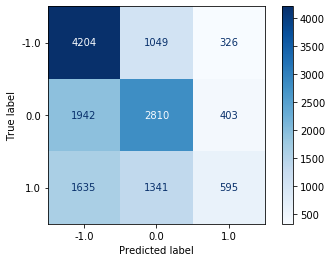

In [49]:
plot_confusion_matrix(boost_c, X_test, y_test, cmap='Blues')

In [57]:
start_time = time.time()

boost_c_smote = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=3, max_features='sqrt')

boost_c_smote.fit(X_train_res, y_train_res)

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

print(boost_c_smote.score(X_train, y_train))
print(boost_c_smote.score(X_test, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

--- 317.0794219970703 seconds ---
0.29938131357265196
0.3027612722824187
--- 2.6010448932647705 seconds ---


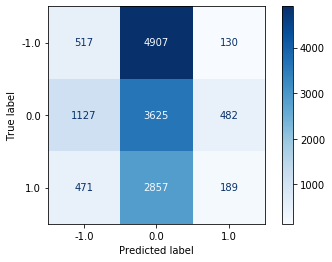

In [58]:
plot_confusion_matrix(boost_c_smote, X_test, y_test, cmap='Blues')

In [66]:
start_time = time.time()

forest_c_smote = RandomForestClassifier(n_estimators=1000, max_depth=3)

forest_c_smote.fit(X_train_res, y_train_res)

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

print(forest_c_smote.score(X_train, y_train))
print(forest_c_smote.score(X_test, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

--- 57.23988914489746 seconds ---
0.3925338180292915
0.3951066060817896
--- 3.3690030574798584 seconds ---


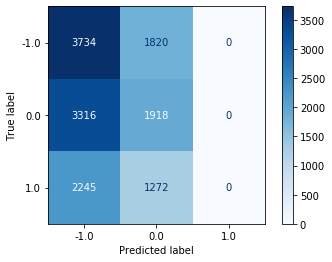

In [67]:
plot_confusion_matrix(forest_c_smote, X_test, y_test, cmap='Blues')

In [68]:
start_time = time.time()

forest_c = RandomForestClassifier(n_estimators=1000, max_depth=3)

forest_c.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

print(forest_c.score(X_train, y_train))
print(forest_c.score(X_test, y_test))

print("--- %s seconds ---" % (time.time() - start_time))

--- 44.738351583480835 seconds ---
0.5046488867139711
0.5102411744145404
--- 4.875996351242065 seconds ---


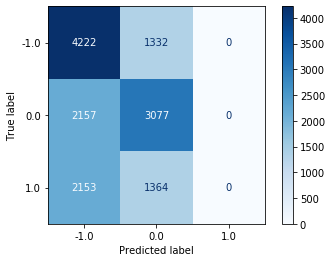

In [69]:
plot_confusion_matrix(forest_c, X_test, y_test, cmap='Blues')

In [54]:
corr = df2015.corr()

In [60]:
corr['Walk'].sort_values()

Drive                -0.614166
Income               -0.190263
TotalPop             -0.151456
MeanCommute          -0.138182
Office               -0.108216
Construction         -0.106854
White                -0.100095
1                    -0.098220
Production           -0.083483
Carpool              -0.082839
IncomePerCap         -0.052361
6                    -0.049590
Poverty_Change_val   -0.034436
IncomeErr            -0.026447
Poverty_Change       -0.025395
PrivateWork          -0.024870
Employed             -0.022496
0                    -0.019866
4                    -0.009585
9                     0.000526
Professional          0.013578
SelfEmployed          0.014958
7                     0.016936
PublicWork            0.017340
3                     0.017346
8                     0.020363
Poverty_Change_2c     0.027859
Citizen               0.032655
Black                 0.032961
Native                0.036751
Hispanic              0.052904
IncomePerCapErr       0.060019
5       

In [63]:
corr['IncomePerCap'].sort_values()

Poverty              -0.624229
ChildPoverty         -0.600801
Service              -0.595458
Production           -0.560606
Unemployment         -0.481057
Construction         -0.418580
Carpool              -0.364063
Hispanic             -0.315332
Black                -0.291415
Office               -0.106758
Native               -0.101346
Poverty_Change_2c    -0.080736
9                    -0.068802
PublicWork           -0.061793
Walk                 -0.052361
8                    -0.037886
7                    -0.034058
PrivateWork          -0.023524
6                    -0.019704
OtherTransp          -0.016652
Men                  -0.008230
Drive                -0.006178
1                    -0.005680
3                     0.028943
4                     0.032946
TotalPop              0.035770
2                     0.054072
5                     0.057187
0                     0.060557
Transit               0.063476
Poverty_Change        0.087864
MeanCommute           0.104618
Poverty_

In [64]:
corr['Citizen'].sort_values()

Hispanic             -0.631301
Carpool              -0.333431
ChildPoverty         -0.287848
2                    -0.284307
Service              -0.278033
Poverty              -0.274941
Construction         -0.245562
Transit              -0.241153
Asian                -0.236377
PrivateWork          -0.220311
0                    -0.213585
1                    -0.210975
TotalPop             -0.201658
Production           -0.198877
3                    -0.198776
MeanCommute          -0.187507
4                    -0.176738
Unemployment         -0.163836
5                    -0.116446
OtherTransp          -0.083944
Black                -0.076243
Poverty_Change_2c    -0.068849
9                    -0.046310
8                    -0.029636
Men                  -0.014855
Walk                  0.032655
7                     0.034906
Native                0.038664
IncomeErr             0.044557
SelfEmployed          0.048437
6                     0.059534
Poverty_Change        0.085707
Income  